In [1]:
import numpy as np
from scipy import *
from pylab import *
import healpy as hp
import os
from healpy import pixelfunc

## Notebook for LSST DESC HOS hack hour (July 19, 2022) - turning HOS codes from flat-sky to curved-sky compatible 
#### Curved sky maps and catalogues generated by Joachim Harnois-Deraps
#### Notebook and flat sky map by Jia Liu 

In [2]:
######## file paths

######## curved sky map
fn_map_curved = '/global/homes/j/jharno/IA-infusion/SkySim5000/kappa/1.0060kappa.npy'

######## shape catalogues of 3 different resolutions
## 6 columns: [ra_degree, dec_degree, shear1, shear2, weight, kappa]

# 0.06 gal/sq.arcmin
fn_cat006 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_0.06GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'
# 0.6 gal/sq.arcmin
fn_cat06 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_0.6GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'
# 1.2 gal/sq.arcmin
fn_cat12 = '/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/zs_plane/GalCat_zplane_zs1.006_1.2GpAM_RA_Dec_gamma1_gamma2_w_kappa.asc'

### Plot the curved sky map with healpy

Nside = 8192
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


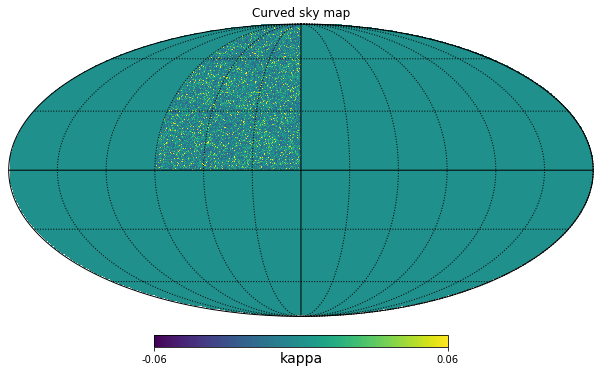

In [3]:
hpmap = np.load(fn_map_curved)

nside = pixelfunc.get_nside(hpmap)
print ('Nside =',nside)

hp.mollview(hpmap,
            title="Curved sky map",
            unit="kappa",
            # norm="hist",
            min=-0.06,
            max=0.06,
            nest=False ## True would be Ring
)

hp.graticule()

### Next, we generate a flat sky map using Gnomonic projection from the curve sky map

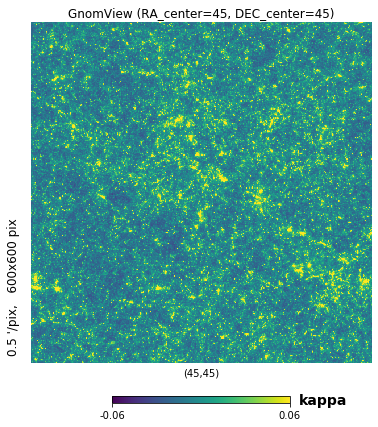

In [4]:
####### free parameters to define the patch to cut out (next 3 lines)
ra0, dec0 = 45, 45 ## center of the patch, unit: degrees; ra, dec both go from [0, 90] deg
mapsize = 5 # map size in degrees
res_arcmin = 0.5 # map resolution in arcmin/pix


Npix = mapsize*60/res_arcmin # number of pixels to cut out (per side)

map_flat = hp.gnomview(hpmap, rot=[ra0, dec0], unit="kappa", format="%.2g",
                       title="GnomView (RA_center=%s, DEC_center=%s)" %(ra0, dec0), 
                       xsize=Npix, ## number of pixels 
                       reso=res_arcmin, ## resolution in arcmin
                       # norm="hist",
                       min=-0.06,
                       max=0.06,
                       return_projected_map=True)

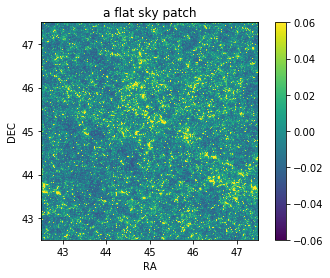

In [5]:
###### show this again with our usual imshow
imshow(map_flat, vmin=-0.06, vmax=0.06, origin='lower left', extent=[ra0-mapsize/2,ra0+mapsize/2, dec0-mapsize/2,dec0+mapsize/2])
xlabel('RA'); ylabel('DEC')
colorbar()
title('a flat sky patch')
show()

### We move on to the catalogues

In [6]:
########## load catalogues

## 6 columns: [ra_degree, dec_degree, shear1, shear2, weight, kappa]
cat_006=np.loadtxt(fn_cat006)
ra_degree, dec_degree,  shear1, shear2, weight, kappa = cat_006.T
print (cat_006.shape)

#### uncomment below lines to get higher density catalogues
# cat_06=np.loadtxt(fn_cat06)
# cat_12=np.loadtxt(fn_cat12)

### Note that e1 needs to be flipped when using treecorr. Please check explicitely for this 
### with your estimator! A wrong sign will produce signal consistent with zero. 

(1113829, 6)


#### we cut out the region that roughly corresponds to the flat sky region above
#### note that this is not strictly a square, as we're cutting on ra, dec and not doing coordinate transform to flat [x, y] 

In [7]:
idx_flat = where((ra_degree < ra0+mapsize/2)
                         & (ra_degree > ra0-mapsize/2)
                         & (dec_degree < dec0+mapsize/2)
                         & (dec_degree > dec0-mapsize/2))

In [8]:
kappa[idx_flat].shape

(3747,)

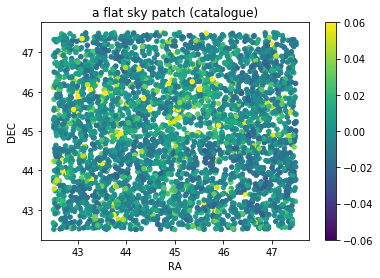

In [9]:
scatter(ra_degree[idx_flat], dec_degree[idx_flat], c=kappa[idx_flat], vmin=-0.06, vmax=0.06,s=20)
xlabel('RA'); ylabel('DEC')
colorbar()
title('a flat sky patch (catalogue)')
show()